# Final Project Report - Natural Language Processing (NLP)

# Group Members

| Họ và tên        | MSSV       | Vai trò        |
|------------------|------------|----------------|
| Trần Bá Đông     | 22280011   | Nhóm trưởng    |
| Lê Viết Tố Khoa  | 22280046   | Thành viên     |
| Đoàn Nhật Nam    | 22280054   | Thành viên     |


## Cài đặt môi trường phụ thuộc

In [ ]:
!pip install numpy==1.*

In [ ]:
!pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 100.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3


In [ ]:
!pip install -U kagglehub[pandas-datasets]

In [ ]:
!pip install -q wordcloud

## 1. Import thư viện

In [ ]:
# ===== THƯ VIỆN PHỔ BIẾN =====
import pandas as pd                         # Xử lý dữ liệu dạng bảng (DataFrame)
import numpy as np                          # Hỗ trợ các phép toán số học, ma trận, mảng
import matplotlib.pyplot as plt             # Thư viện vẽ biểu đồ 2D cơ bản
import seaborn as sns                       # Thư viện vẽ biểu đồ thống kê đẹp, trực quan hơn matplotlib

# XỬ LÝ VĂN BẢN
import re                                   # Thư viện xử lý biểu thức chính quy (regex)
import string                               # Cung cấp các ký tự đặc biệt (punctuation, ascii, ...)

# ===== EDA MỞ RỘNG (BỔ SUNG) =====
from wordcloud import WordCloud             # Vẽ biểu đồ WordCloud để minh họa tần suất từ
from collections import Counter             # Đếm tần suất xuất hiện (dùng cho word/token stats)
from sklearn.feature_extraction.text import CountVectorizer  # Biểu diễn văn bản dạng Bag-of-Words (n-gram)

# ===== XỬ LÝ DỮ LIỆU & MÔ HÌNH =====
import torch                                # Thư viện deep learning PyTorch
from datasets import Dataset, DatasetDict   # Thư viện của HuggingFace để quản lý tập dữ liệu huấn luyện (train/test/val)

# ===== THƯ VIỆN SCiKIT-LEARN =====
from sklearn.model_selection import train_test_split         # Chia dữ liệu train/val/test
from sklearn.metrics import (                                 # Đánh giá mô hình
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

# ===== TRANSFORMERS (HUGGINGFACE) =====
from transformers import (
    AutoTokenizer,                          # Tự động tải tokenizer theo tên mô hình
    AutoModelForSequenceClassification,     # Mô hình phân loại văn bản (Sequence Classification)
    Trainer, TrainingArguments,             # API huấn luyện cao cấp của HuggingFace
    DataCollatorWithPadding,                # Tự động padding batch văn bản trong quá trình train
    EarlyStoppingCallback                   # Hỗ trợ dừng khi kết quả train không cải thiện
)

# ===== KAGGLE HUB =====
import kagglehub                            # Thư viện hỗ trợ tải dữ liệu trực tiếp từ Kaggle (không cần tải tay)
from kagglehub import KaggleDatasetAdapter  # Adapter để lấy dữ liệu dưới dạng DataFrame từ KaggleHub

# ===== WANDB & HUGGINGFACE LOGIN =====
import wandb                                # Weights & Biases để theo dõi quá trình huấn luyện (logs, charts, metrics)

# Đăng nhập vào HuggingFace để tải mô hình/tokenizer từ HuggingFace Hub
from huggingface_hub import login
login(token="...")

# Đăng nhập vào Weights & Biases để lưu lịch sử huấn luyện
wandb.login(key='...')

2025-06-16 19:09:13.189425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750100953.441831      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750100953.513535      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.

True

## 2. Các class xử lý chính

### 2.1 Tải dữ liệu từ KaggleHub

In [ ]:
class KaggleDataLoader:
    def __init__(self, dataset_id, true_filename, fake_filename):
        self.dataset_id = dataset_id
        self.true_filename = true_filename
        self.fake_filename = fake_filename

    def load(self):
        df_true = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, self.dataset_id, self.true_filename)
        df_fake = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, self.dataset_id, self.fake_filename)

        df_true['label'] = 1
        df_fake['label'] = 0
        return pd.concat([df_true, df_fake], ignore_index=True)


🔹 Chức năng:

Tải dữ liệu từ Kaggle thông qua thư viện kagglehub.

Gộp dữ liệu từ 2 file (True.csv và Fake.csv) và gán nhãn tương ứng (1 cho TRUE, 0 cho FALSE).

🔸 Đầu ra:

Một pandas.DataFrame gồm 2 cột: text và label.



2.2 Tiền xử lý và EDA

In [ ]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

class EDAVisualizer:
    def __init__(self, df):
        self.df = df.copy()
        self.df['text_length'] = self.df['text'].apply(lambda x: len(str(x).split()))

    def profile(self):
        print("📌 Thông tin thiếu:")
        print(self.df.isnull().sum(), '\n')

        print("📌 Số bản ghi trùng lặp:", self.df.duplicated().sum())

        print("\n📌 Thống kê mô tả:")
        print(self.df.describe(include='all'))

    def visualize(self):
        # 1. Biểu đồ phân phối nhãn
        print("\n📊 Biểu đồ: Phân phối nhãn (số lượng tin thật và giả)")
        plt.figure(figsize=(6, 4))
        sns.countplot(x='label', data=self.df, palette='Set2')
        plt.title('Phân phối nhãn (Label Distribution)', fontsize=13)
        plt.xlabel('Label (0: GIẢ, 1: THẬT)')
        plt.ylabel('Số lượng mẫu')
        plt.tight_layout()
        plt.show()

        # 2. Biểu đồ độ dài văn bản
        print("\n📊 Biểu đồ: Phân phối độ dài văn bản (tính theo số từ)")
        plt.figure(figsize=(8, 4))
        sns.histplot(self.df['text_length'], bins=50, kde=True, color='teal')
        plt.title('Phân phối độ dài văn bản', fontsize=13)
        plt.xlabel('Số từ trong văn bản')
        plt.ylabel('Tần suất')
        plt.tight_layout()
        plt.show()

        # 3. WordCloud cho văn bản THẬT
        print("\n☁️ WordCloud: Các từ phổ biến trong tin THẬT")
        true_text = ' '.join(self.df[self.df['label'] == 1]['text'].astype(str))
        plt.figure(figsize=(10, 5))
        wc_true = WordCloud(width=800, height=400, background_color='white').generate(true_text)
        plt.imshow(wc_true, interpolation='bilinear')
        plt.axis('off')
        plt.title('WordCloud - Tin THẬT', fontsize=14)
        plt.tight_layout()
        plt.show()

        # 4. WordCloud cho văn bản GIẢ
        print("\n☁️ WordCloud: Các từ phổ biến trong tin GIẢ")
        fake_text = ' '.join(self.df[self.df['label'] == 0]['text'].astype(str))
        plt.figure(figsize=(10, 5))
        wc_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
        plt.imshow(wc_fake, interpolation='bilinear')
        plt.axis('off')
        plt.title('WordCloud - Tin GIẢ', fontsize=14)
        plt.tight_layout()
        plt.show()

        # 5. Top 20 frequent unigrams & bigrams
        print("\n📈 Biểu đồ: Top 20 unigram & bigram phổ biến nhất")
        vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english', max_features=20)
        X = vectorizer.fit_transform(self.df['text'].astype(str))
        ngram_counts = X.sum(axis=0).A1
        vocab = vectorizer.get_feature_names_out()
        freq_df = pd.DataFrame({'ngram': vocab, 'count': ngram_counts})
        freq_df = freq_df.sort_values(by='count', ascending=False)

        plt.figure(figsize=(10, 5))
        sns.barplot(x='count', y='ngram', data=freq_df, palette='mako')
        plt.title("Top 20 Frequent Unigrams + Bigrams", fontsize=13)
        plt.xlabel("Tần suất")
        plt.ylabel("N-gram")
        plt.tight_layout()
        plt.show()


🔹 Chức năng:

Thực hiện khám phá dữ liệu (EDA):

- Kiểm tra dữ liệu thiếu, trùng lặp.

- Thống kê mô tả.

- Vẽ biểu đồ: phân phối nhãn, độ dài văn bản, word cloud, top n-grams.

🔸 Đầu ra:

In thông tin và hiển thị các biểu đồ trực quan bằng matplotlib/seaborn.

In [ ]:
class DataPreprocessor:
    def __init__(self, df):
        self.df = df

    def preprocess(self):
        df = self.df.drop_duplicates()
        df = df.dropna(subset=['text'])
        return df[['text', 'label']].reset_index(drop=True)


🔹 Chức năng:

Làm sạch dữ liệu cơ bản:

- Loại bỏ dòng trùng (drop_duplicates),

- Bỏ dòng null (dropna ở cột text),

- Giữ lại 2 cột cần thiết (text, label).

🔸 Đầu ra:

Trả về DataFrame đã làm sạch (clean_text, label).

### 2.3 Tokenizer & Dataset

In [ ]:
class TextDatasetBuilder:
    def __init__(self, df, model_name):
        self.df = df
        self.model_name = model_name.lower()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize_function(self, examples):
        padding = 'max_length' if "xlnet" in self.model_name else False
        return self.tokenizer(examples['text'], padding=padding, truncation=True, max_length=512)

    def build(self):
        self.df['text'] = self.df['text'].astype(str)
        texts, labels = self.df['text'].values, self.df['label'].astype(np.int32).values

        # Bước 1: Chia thành train (80%) và temp (val + test: 20%)
        X_train, X_temp, y_train, y_temp = train_test_split(
            texts, labels, test_size=0.2, stratify=labels, random_state=42
        )

        # Bước 2: Chia temp thành validation (10%) và test (10%)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
        )

        # Thống kê số lượng
        print(f"Số lượng mẫu:")
        print(f"  Train      : {len(X_train)}")
        print(f"  Validation : {len(X_val)}")
        print(f"  Test       : {len(X_test)}")

        # Tạo DatasetDict
        dataset = DatasetDict({
            'train': Dataset.from_dict({'text': X_train.tolist(), 'label': y_train.tolist()}),
            'validation': Dataset.from_dict({'text': X_val.tolist(), 'label': y_val.tolist()}),
            'test': Dataset.from_dict({'text': X_test.tolist(), 'label': y_test.tolist()})
        })

        dataset = dataset.map(self.tokenize_function, batched=True)
        dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

        data_collator = None
        if "xlnet" not in self.model_name:
            data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer, return_tensors="pt")

        return dataset, self.tokenizer, data_collator


🔹 Chức năng:

Tokenize văn bản sử dụng transformers.AutoTokenizer.

Chuyển DataFrame thành DatasetDict gồm 3 tập: train, validation, test.

🔸 Đầu ra:

Tuple gồm:

- DatasetDict (gồm train, test)

- tokenizer

- data_collator (dùng cho Trainer nếu cần padding động)

### 2.4 Huấn luyện mô hình

In [ ]:
class ModelBuilder:
    def __init__(self, model_name):
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
        if torch.cuda.is_available():
            self.model.to('cuda')

    def get_model(self):
        return self.model


🔹 Chức năng:

Tải mô hình transformer (BERT, RoBERTa, XLNet, v.v.) từ HuggingFace phù hợp với classification.

Di chuyển mô hình lên GPU nếu có.

🔸 Đầu ra:

Trả về AutoModelForSequenceClassification đã cấu hình sẵn.

In [ ]:
class ModelTrainer:
    def __init__(self, model, dataset, model_name, data_collator=None):
        # Khởi tạo lớp huấn luyện với các thành phần cần thiết
        self.model = model                                # Mô hình (BERT, RoBERTa, XLNet, ...)
        self.dataset = dataset                            # Dataset đã được chia train/validation/test
        self.data_collator = data_collator                # Hàm padding/gộp mẫu (nếu cần)
        self.model_name = model_name                      # Tên mô hình (để lưu kết quả và log)

    def compute_metrics(self, eval_pred):
        # Tính toán các chỉ số đánh giá từ kết quả dự đoán
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)                # Chọn nhãn có xác suất cao nhất
        return {
            'accuracy': accuracy_score(labels, preds),    # Độ chính xác
            'precision': precision_score(labels, preds),  # Độ chính xác của nhãn dương
            'recall': recall_score(labels, preds),        # Tỷ lệ phát hiện đúng nhãn dương
            'f1': f1_score(labels, preds)                 # Trung bình điều hòa của precision và recall
        }

    def train(self):
        # Thiết lập các đối số huấn luyện
        training_args = TrainingArguments(
            output_dir=f"./results/{self.model_name}",     # Thư mục lưu checkpoint mô hình
            eval_strategy="epoch",                         # Đánh giá sau mỗi epoch
            save_strategy="epoch",                         # Lưu mô hình sau mỗi epoch
            logging_strategy="epoch",                      # Ghi log sau mỗi epoch
            logging_steps=100,                             # Nếu logging theo steps thì ghi mỗi 100 bước
            per_device_train_batch_size=32,                # Batch size cho huấn luyện
            per_device_eval_batch_size=64,                 # Batch size cho đánh giá
            num_train_epochs=10,                           # Số epoch huấn luyện
            learning_rate=5e-5,                            # Tốc độ học
            weight_decay=0.01,                             # Tránh overfitting bằng weight decay
            load_best_model_at_end=True,                   # Tự động tải lại mô hình tốt nhất sau huấn luyện
            metric_for_best_model="f1",                    # Tiêu chí để chọn mô hình tốt nhất là F1-score
            logging_dir="./logs",                          # Thư mục log cho TensorBoard/WandB
            fp16=True,                                     # Dùng mixed-precision (FP16) nếu có GPU hỗ trợ
            report_to="wandb",                             # Gửi log đến Weights & Biases
            save_total_limit=1                             # Chỉ giữ lại 1 checkpoint tốt nhất
        )

        # Khởi tạo Trainer của HuggingFace
        trainer = Trainer(
            model=self.model,                              # Mô hình Transformer đã được build
            args=training_args,                            # Các thiết lập huấn luyện
            train_dataset=self.dataset["train"],           # Tập huấn luyện
            eval_dataset=self.dataset["validation"],       # Tập đánh giá
            tokenizer=None,                                # Không cần tokenizer nếu đã xử lý đầu vào sẵn
            data_collator=self.data_collator,              # Hàm xử lý batch (nếu cần padding động)
            compute_metrics=self.compute_metrics,          # Hàm tính metrics
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Dừng sớm nếu không cải thiện
        )

        # Thực hiện huấn luyện
        trainer.train()

        # Trả về trainer đã huấn luyện (để dùng tiếp trong đánh giá, test, predict)
        return trainer


🔹 Chức năng:

Cấu hình và khởi tạo transformers.Trainer với:

- Mô hình, tập huấn luyện, args huấn luyện.

- Logging W&B, batch size, epochs, early stopping, evaluation metric,...

🔸 Đầu ra:

Trả về một Trainer đã được train.

### 2.5 Đánh giá

In [ ]:
class ModelEvaluator:
    def __init__(self, trainer, dataset):
        self.trainer = trainer
        self.dataset = dataset

    def evaluate(self):
        predictions = self.trainer.predict(self.dataset['test'])
        preds = np.argmax(predictions.predictions, axis=-1)
        labels = predictions.label_ids

        print(classification_report(labels, preds))
        cm = confusion_matrix(labels, preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()


🔹 Chức năng:

Đánh giá mô hình trên tập test.

In:

- Accuracy, Precision, Recall, F1.

- Confusion matrix.

- Classification report.

🔸 Đầu ra:

Không trả về gì, chỉ in và vẽ biểu đồ đánh giá mô hình.

## 3. Quản lý toàn bộ pipeline

In [ ]:
class FakeNewsPipelineManager:
    def __init__(self, dataset_id, true_filename, fake_filename):
        self.dataset_id = dataset_id
        self.true_filename = true_filename
        self.fake_filename = fake_filename
        self.df = None
        self.processed_df = None
        self.dataset = None
        self.tokenizer = None
        self.data_collator = None
        self.model = None
        self.trainer = None
        self.label_map = {0: "FAKE", 1: "REAL"}  # Mapping dự đoán sang nhãn

    def load_and_eda(self):
        self.df = KaggleDataLoader(self.dataset_id, self.true_filename, self.fake_filename).load()
        EDAVisualizer(self.df).profile()
        EDAVisualizer(self.df).visualize()

    def preprocess(self):
        self.processed_df = DataPreprocessor(self.df).preprocess()

    def tokenize(self, model_name):
        builder = TextDatasetBuilder(self.processed_df, model_name)
        self.dataset, self.tokenizer, self.data_collator = builder.build()

    def run_model(self, model_name):
        self.model = ModelBuilder(model_name).get_model()
        self.trainer = ModelTrainer(self.model, self.dataset, model_name, self.data_collator).train()
        ModelEvaluator(self.trainer, self.dataset).evaluate()

    def predict(self, texts):
        if self.model is None or self.tokenizer is None:
            raise ValueError("⚠️ Bạn cần huấn luyện mô hình trước khi dự đoán (gọi run_model và tokenize).")

        # Đảm bảo mô hình ở chế độ eval
        self.model.eval()

        # Tiền xử lý văn bản đầu vào
        inputs = self.tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

        # Đưa inputs về đúng device
        device = next(self.model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Dự đoán
        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1).tolist()

        # Trả kết quả dạng: [(text, nhãn dự đoán)]
        return [(text, self.label_map[pred]) for text, pred in zip(texts, preds)]


🔹 Chức năng:

Pipeline tổng hợp:

- Tải dữ liệu

- Làm sạch và trực quan hóa

- Token hóa và tạo dataset

- Tải mô hình và huấn luyện

- Đánh giá

🔸 Đầu ra:

In kết quả huấn luyện & đánh giá, không trả object.

## 4. Sử dụng Pipeline: Huấn luyện nhiều mô hình


/tmp/ipykernel_19/2519023560.py:8: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df_true = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, self.dataset_id, self.true_filename)
/tmp/ipykernel_19/2519023560.py:9: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df_fake = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, self.dataset_id, self.fake_filename)


📌 Thông tin thiếu:
Unnamed: 0      0
text           29
label           0
text_length     0
dtype: int64 

📌 Số bản ghi trùng lặp: 0

📌 Thống kê mô tả:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


          Unnamed: 0                                               text  \
count   78617.000000                                              78588   
unique           NaN                                              68604   
top              NaN  Killing Obama administration rules, dismantlin...   
freq             NaN                                                 58   
mean    20155.362250                                                NaN   
std     11970.272823                                                NaN   
min         0.000000                                                NaN   
25%      9827.000000                                                NaN   
50%     19958.000000                                                NaN   
75%     29834.000000                                                NaN   
max     44426.000000                                                NaN   

               label   text_length  
count   78617.000000  78617.000000  
unique           NaN     

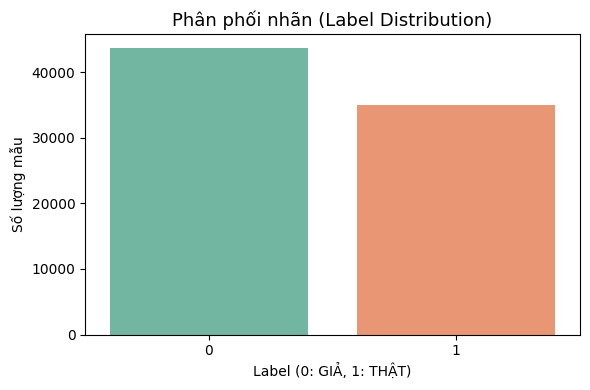


📊 Biểu đồ: Phân phối độ dài văn bản (tính theo số từ)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


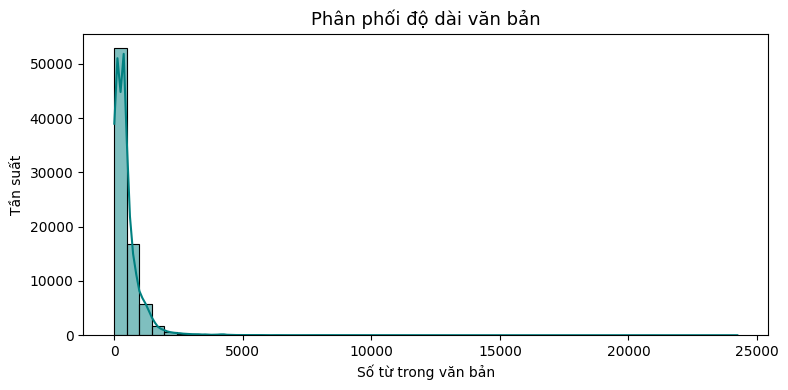


☁️ WordCloud: Các từ phổ biến trong tin THẬT


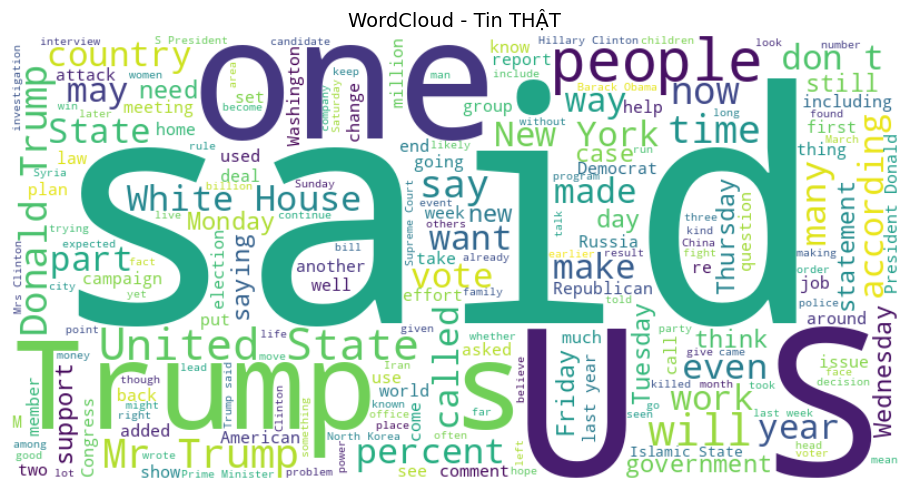


☁️ WordCloud: Các từ phổ biến trong tin GIẢ


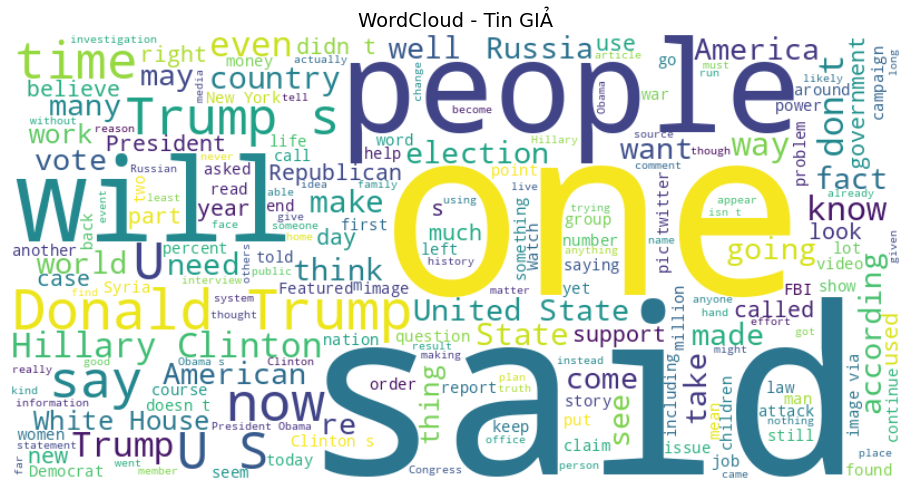


📈 Biểu đồ: Top 20 unigram & bigram phổ biến nhất


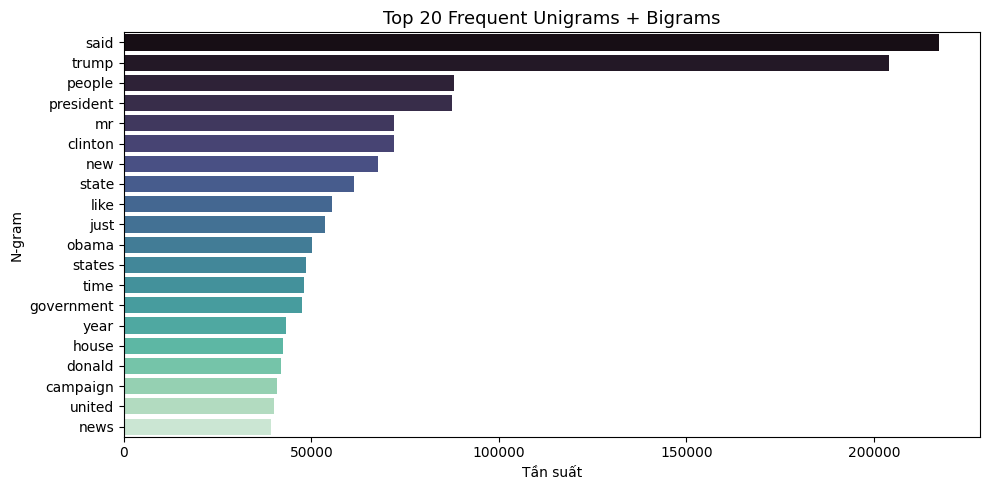

In [ ]:
pipeline = FakeNewsPipelineManager(
    dataset_id="basdong/fake-news-dataset",
    true_filename="DataSet_Misinfo_TRUE.csv",
    fake_filename="DataSet_Misinfo_FAKE.csv"
)

pipeline.load_and_eda()
pipeline.preprocess()


### 4.1 Mô hình BERT

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Số lượng mẫu:
  Train      : 62870
  Validation : 7859
  Test       : 7859


Map:   0%|          | 0/62870 [00:00<?, ? examples/s]

Map:   0%|          | 0/7859 [00:00<?, ? examples/s]

Map:   0%|          | 0/7859 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/3491466486.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250616_191400-aq5ix9fr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results/bert-base-uncased
wandb: ⭐️ View project at https://wandb.ai/tranbadong-i-h-c-qu-c-gia-tp

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.069300,0.074590,0.985113,0.995599,0.970815,0.983051
2,0.022700,0.051677,0.989693,0.979764,0.997425,0.988516
3,0.011700,0.036284,0.993256,0.993689,0.991130,0.992408
4,0.008700,0.057188,0.990839,0.997674,0.981688,0.989616
5,0.004600,0.043745,0.993511,0.994828,0.990558,0.992688
6,0.004300,0.040675,0.993256,0.987535,0.997425,0.992456
7,0.002400,0.040616,0.992747,0.994534,0.989127,0.991823


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4365
           1       0.99      0.99      0.99      3494

    accuracy                           0.99      7859
   macro avg       0.99      0.99      0.99      7859
weighted avg       0.99      0.99      0.99      7859



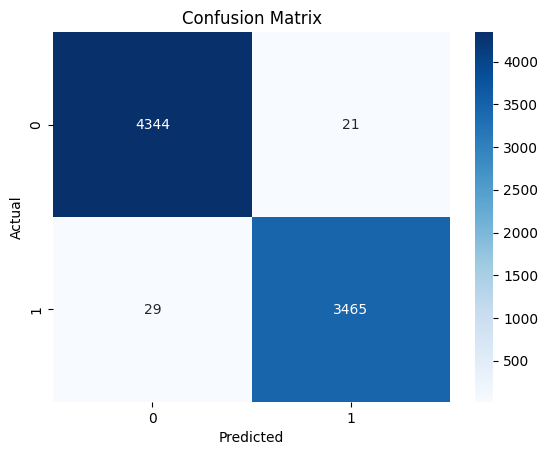

In [ ]:
# Tokenize & Train with BERT
pipeline.tokenize("bert-base-uncased")
pipeline.run_model("bert-base-uncased")

In [ ]:
# Dự đoán 5 mẫu văn bản
test_texts = [
    "NASA confirms presence of microbial life on Europa.",
    "Bill Gates to implant tracking chips via vaccines, claims viral post.",
    "Biden signs executive order on AI regulation.",
    "Apple releases new iPhone model with brainwave control.",
    "WHO warns of new COVID variant emerging in Southeast Asia."
]

predictions = pipeline.predict(test_texts)
for text, label in predictions:
    print(f"📰 \"{text}\" → Dự đoán: {label}")

📰 "NASA confirms presence of microbial life on Europa." → Dự đoán: FAKE
📰 "Bill Gates to implant tracking chips via vaccines, claims viral post." → Dự đoán: FAKE
📰 "Biden signs executive order on AI regulation." → Dự đoán: FAKE
📰 "Apple releases new iPhone model with brainwave control." → Dự đoán: FAKE
📰 "WHO warns of new COVID variant emerging in Southeast Asia." → Dự đoán: FAKE


### 4.2 Mô hình RoBERTa

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Số lượng mẫu:
  Train      : 62870
  Validation : 7859
  Test       : 7859


Map:   0%|          | 0/62870 [00:00<?, ? examples/s]

Map:   0%|          | 0/7859 [00:00<?, ? examples/s]

Map:   0%|          | 0/7859 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/3491466486.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250616_191616-5uy8dk8t
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results/roberta-base
wandb: ⭐

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.041500,0.017945,0.996692,0.996280,0.996280,0.996280
2,0.018600,0.018279,0.997201,0.995435,0.998283,0.996857
3,0.015300,0.025315,0.996055,0.996275,0.994850,0.995562
4,0.018800,0.015786,0.997582,0.999712,0.994850,0.997275
5,0.016400,0.018548,0.997073,0.998564,0.994850,0.996703
6,0.007600,0.012212,0.998091,0.998282,0.997425,0.997853
7,0.006000,0.014217,0.998091,0.997997,0.997711,0.997854
8,0.003600,0.017063,0.997710,0.996572,0.998283,0.997427
9,0.002600,0.013574,0.998219,0.997712,0.998283,0.997998
10,0.001100,0.012530,0.998346,0.997998,0.998283,0.998140


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4365
           1       1.00      1.00      1.00      3494

    accuracy                           1.00      7859
   macro avg       1.00      1.00      1.00      7859
weighted avg       1.00      1.00      1.00      7859



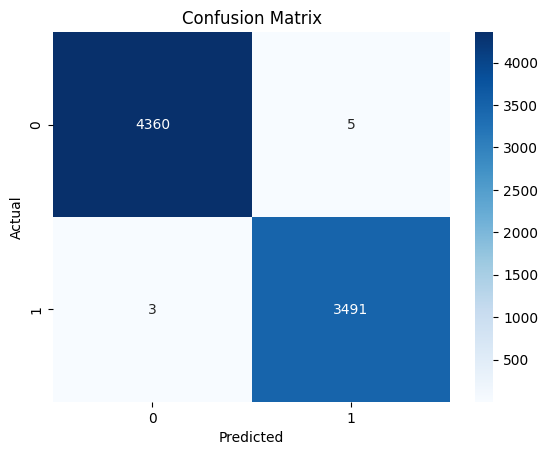

In [ ]:
# Tokenize & Train with RoBERTa
pipeline.tokenize("roberta-base")
pipeline.run_model("roberta-base")

In [ ]:
# Dự đoán 5 mẫu văn bản
test_texts = [
    "NASA confirms presence of microbial life on Europa.",
    "Bill Gates to implant tracking chips via vaccines, claims viral post.",
    "Biden signs executive order on AI regulation.",
    "Apple releases new iPhone model with brainwave control.",
    "WHO warns of new COVID variant emerging in Southeast Asia."
]

predictions = pipeline.predict(test_texts)
for text, label in predictions:
    print(f"📰 \"{text}\" → Dự đoán: {label}")

📰 "NASA confirms presence of microbial life on Europa." → Dự đoán: FAKE
📰 "Bill Gates to implant tracking chips via vaccines, claims viral post." → Dự đoán: FAKE
📰 "Biden signs executive order on AI regulation." → Dự đoán: FAKE
📰 "Apple releases new iPhone model with brainwave control." → Dự đoán: FAKE
📰 "WHO warns of new COVID variant emerging in Southeast Asia." → Dự đoán: FAKE


### 4.3 Mô hình XLNet

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Số lượng mẫu:
  Train      : 62870
  Validation : 7859
  Test       : 7859


Map:   0%|          | 0/62870 [00:00<?, ? examples/s]

Map:   0%|          | 0/7859 [00:00<?, ? examples/s]

Map:   0%|          | 0/7859 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/2417067258.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250617_055915-hnwpgi1k
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results/xlnet-base-cased
wandb: ⭐️ View project at https://wandb.ai/tranbadong-i-h-c-qu-c-gia-tp-hcm/huggingface
wandb: 🚀 View run at https://wandb.ai/tranbadong-i-h-c-qu-c-gia-tp-hcm/huggingface/runs/hnwpgi1k


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.080700,0.077993,0.985113,0.988715,0.977682,0.983168
2,0.268600,0.689169,0.555287,0.000000,0.000000,0.000000
3,0.668900,1.688094,0.555287,0.000000,0.000000,0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4365
           1       0.99      0.99      0.99      3494

    accuracy                           0.99      7859
   macro avg       0.99      0.99      0.99      7859
weighted avg       0.99      0.99      0.99      7859



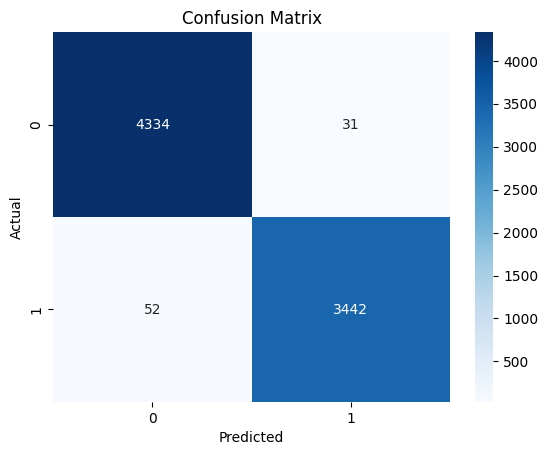

In [ ]:
# Tokenize & Train with XLNet
pipeline.tokenize("xlnet-base-cased")
pipeline.run_model("xlnet-base-cased")

In [ ]:
# Dự đoán 5 mẫu văn bản
test_texts = [
    "NASA confirms presence of microbial life on Europa.",
    "Bill Gates to implant tracking chips via vaccines, claims viral post.",
    "Biden signs executive order on AI regulation.",
    "Apple releases new iPhone model with brainwave control.",
    "WHO warns of new COVID variant emerging in Southeast Asia."
]

predictions = pipeline.predict(test_texts)
for text, label in predictions:
    print(f"📰 \"{text}\" → Dự đoán: {label}")

📰 "NASA confirms presence of microbial life on Europa." → Dự đoán: FAKE
📰 "Bill Gates to implant tracking chips via vaccines, claims viral post." → Dự đoán: FAKE
📰 "Biden signs executive order on AI regulation." → Dự đoán: FAKE
📰 "Apple releases new iPhone model with brainwave control." → Dự đoán: FAKE
📰 "WHO warns of new COVID variant emerging in Southeast Asia." → Dự đoán: FAKE


## 5. Kết luận và hướng phát triển

### 5.1 Kết luận

Trong đồ án, nhóm đã xây dựng một pipeline dùng để phát hiện tin thật giả dựa trên các mô hình Transformer: BERT, RoBERTa và XLNet.
Cấu trúc pipeline được thiết kế module hóa rõ ràng với các bước:
- Tiền xử lý dữ liệu (Preprocessing).
- Phân tích dữ liệu khám phá (EDA – Exploratory Data Analysis).
- Tokenization và DataLoader.
- Huấn luyện mô hình (Model Training).
- Đánh giá mô hình (Evaluation).
- Suy diễn (Inference).



Hệ thống được thiết kế với cấu trúc module hóa rõ ràng theo pipeline hiện đại của NLP, đảm bảo tái sử dụng, hiệu quả, và dễ mở rộng.

Kết quả thực nghiệm:

| Mô hình     | Accuracy | Precision | Recall | F1-Score   | Best Epoch | Training Time                           |
| ----------- | -------- | --------- | ------ | ---------- | ---------- | --------------------------------------- |
| **RoBERTa** | 99.83%   | 99.80%    | 99.83% | **99.81%** | Epoch 10   | 8 giờ 53 phút                           |
| **BERT**    | 99.35%   | 99.45%    | 99.13% | **99.18%** | Epoch 5    | 6 giờ 11 phút                           |
| **XLNet**   | 98.51%   | 98.87%    | 97.77% | **98.32%** | Epoch 1    | 5 giờ 13 phút (dừng sớm do overfitting) |



Dựa vào kết quả thực nghiệm:
- RoBERTa là mô hình có hiệu suất cao nhất trên cả bốn chỉ số chính (Accuracy, Precision, Recall, F1), đạt F1-score lên tới 99.81%. Điều này cho thấy kiến trúc huấn luyện cải tiến và khả năng học sâu của RoBERTa rất phù hợp cho bài toán phân loại tin giả.

- BERT tuy có thời gian huấn luyện ngắn hơn, nhưng vẫn duy trì được hiệu suất rất tốt (F1-score 99.18%), chứng minh hiệu quả mạnh mẽ và ổn định của mô hình gốc.

- XLNet, mặc dù có tiềm năng và đạt F1-score 98.32% tại epoch đầu, nhưng lại nhanh chóng overfit và sụt giảm nghiêm trọng ở các epoch tiếp theo. Do đó, early stopping ở epoch 1 là cần thiết để đảm bảo hiệu quả.

Các kết quả đạt được khẳng định rằng mô hình Transformer, đặc biệt là RoBERTa, có thể được ứng dụng hiệu quả vào các hệ thống phát hiện và lọc nội dung giả mạo trong môi trường báo chí số, mạng xã hội hoặc nền tảng tin tức trực tuyến.

Với kết quả PREDICT, cả ba mô hình đều cho ra 1 kết quả:
📰 "NASA confirms presence of microbial life on Europa." → Dự đoán: FAKE

📰 "Bill Gates to implant tracking chips via vaccines, claims viral post." → Dự đoán: FAKE

📰 "Biden signs executive order on AI regulation." → Dự đoán: FAKE

📰 "Apple releases new iPhone model with brainwave control." → Dự đoán: FAKE

📰 "WHO warns of new COVID variant emerging in Southeast Asia." → Dự đoán: FAKE

Điều này chứng tỏ các mô hình đều thể hiện tính ổn định và độ tin cậy cao, học được các đặc trưng sâu của tin giả và không bị dao động bởi từ khóa như NASA, WHO, Bill Gates,..

### 5.2 Hướng phát triển

Mở rộng mô hình và fine-tuning chuyên sâu:
- Sử dụng các mô hình tiên tiến như DeBERTa, Longformer, RoBERTa-large,...
- Fine-tuning sâu hơn: áp dụng các kỹ thuật gradual unfreezing, layer-wise learning rate decay, hoặc discriminative learning rate để mô hình học hiệu quả hơn.

Thu thập thêm dữ liệu huấn luyện (đa ngôn ngữ và ngữ cảnh từ nhiều nguồn, ...)

Tối ưu hóa mô hình (Dùng quantization, pruning, hoặc knowledge distillation để giảm kích thước mô hình mà vẫn giữ hiệu suất) và triển khai thành ứng dụng web/mobile.

Nâng cao tính giải thích của mô hình: tích hợp công cụ như LIME, SHAP hoặc attention visualization để giải thích vì sao mô hình phân loại một văn bản là FAKE hay REAL.

Đánh giá mô hình theo chiều sâu: Dùng thêm các chỉ số ngoài F1 như MCC hoặc AUROC.
